This tutorial is available on the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/2023.3.0-updates/pipeline-architecture/wallaroo-arm-cv-demonstration).

This tutorial demonstrates how to use the Wallaroo combined with ARM processors to perform inferences with pre-trained computer vision ML models.  This demonstration assumes that:

* A Wallaroo version 2023.3 or above instance is installed.
* A nodepools with ARM architecture virtual machines are part of the Kubernetes cluster.  For example, Azure supports Ampere® Altra® Arm-based processor included with the following virtual machines:
  * [Dpsv5 and Dpdsv5-series](https://learn.microsoft.com/en-us/azure/virtual-machines/dpsv5-dpdsv5-series)
  * [Epsv5 and Epdsv5-series](https://learn.microsoft.com/en-us/azure/virtual-machines/epsv5-epdsv5-series)
* The applications and modules specified in the notebook `arm-computer-vision-preparation.ipynb` are complete.

### Tutorial Goals

For our example, we will perform the following:

* Create a workspace for our work.
* Upload the the resnet computer vision model model.
* Create a pipeline using the default architecture that can ingest our submitted data, submit it to the model, and export the results while tracking how long the inference took.
* Redeploy the same pipeline on the ARM architecture, then perform the same inference on the same data and model and track how long the inference took.
* Compare the inference timing through the default architecture versus the ARM architecture.

## Steps

### Import Libraries

The first step will be to import our libraries.

In [20]:
import torch
import pickle
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

import numpy as np
import json
import requests
import time
import pandas as pd

# used to display dataframe information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

# used for unique connection names

# import string
# import random
# suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

from CVDemoUtils import CVDemo
cvDemo = CVDemo()
cvDemo.COCO_CLASSES_PATH = "./models/coco_classes.pickle"

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local service

wl = wallaroo.Client()

Please log into the following URL in a web browser:

	https://peters-arm-test.keycloak.wallaroocommunity.ninja/auth/realms/master/device?user_code=XQHV-UCRK

Login successful!


### Set Variables

The following variables and methods are used later to create or connect to an existing workspace, pipeline, and model.

The `suffix` is used to ensure unique workspace names across the Wallaroo instance.

In [3]:
suffix='arm'

workspace_name = f'armexample{suffix}'
pipeline_name = 'cv-sample'


mobilenet_model_name = 'mobilenet'
mobilenet_model_file_name = 'models/mobilenet.pt.onnx'
resnet_model_name = 'resnet'
resnet_model_file_name = 'models/frcnn-resnet.pt.onnx'

In [4]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

### Create Workspace

The workspace will be created or connected to, and set as the default workspace for this session.  Once that is done, then all models and pipelines will be set in that workspace.

In [5]:
workspace = get_workspace(workspace_name)
wl.set_current_workspace(workspace)
wl.get_current_workspace()

{'name': 'armexamplearm', 'id': 23, 'archived': False, 'created_by': 'ce2286c9-caaa-4b2e-b5f4-3a1fea72b5bc', 'created_at': '2023-08-15T16:29:14.320283+00:00', 'models': [], 'pipelines': []}

### Create Pipeline and Upload Model

We will now create or connect to our pipeline and add our CV model as a pipeline step.

In [6]:
pipeline = get_pipeline(pipeline_name)

# mobilenet_model = wl.upload_model(mobilenet_model_name, mobilenet_model_file_name, framework=Framework.ONNX).configure(batch_config="single")
resnet_model = wl.upload_model(resnet_model_name, resnet_model_file_name, framework=Framework.ONNX).configure(batch_config="single")

### Deploy Pipeline

With the model uploaded, we can add it is as a step in the pipeline, then deploy it.

For this deployment we will be using the default deployment which uses the x86 architecture.


Once deployed, resources from the Wallaroo instance will be reserved and the pipeline will be ready to use the model to perform inference requests. 

In [11]:
x86_deployment_config = wallaroo.deployment_config.DeploymentConfigBuilder().cpus(2).memory('2Gi').build()
# clear previous steps
pipeline.clear()
pipeline.add_model_step(resnet_model)

pipeline.deploy(deployment_config = x86_deployment_config)

Waiting for deployment - this will take up to 45s ... ok


name,cv-sample
created,2023-08-15 16:29:14.576736+00:00
last_updated,2023-08-15 16:31:34.624923+00:00
deployed,True
tags,
versions,"39cfff0f-3568-46d5-b130-28e71fc2cfbc, d85773a5-380c-426a-9437-4b5554356841, 509aa270-60f4-48c5-9ba9-2f0af5778ed1, 0accc01a-4600-41d8-8a6b-262685b4ee8e, 88d0089e-7a82-4c21-b490-1a2eaa1d7a01"
steps,resnet


### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.  Once complete, it the image will be converted to a numpy ndim array and added to a dictionary.

In [13]:
##  blank space to create test data, and send some data to your model

image = './data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )

### Run Inference

With that done, we can have the model detect the objects on the image by running an inference through the pipeline, and storing the results for the next step.

This first example will show the time delta between when we start until we have an inference result.

In [18]:
startTime = time.time()
# pass the dataframe in 
results = pipeline.infer(dfImage, dataset=["*", "metadata.elapsed"])
endTime = time.time()
x86_time = endTime-startTime

### Draw the Inference Results

With our inference results, we can take them and use the Wallaroo CVDemo class and draw them onto the original image.  The bounding boxes and the confidence value will only be drawn on images where the model returned a 90% confidence rate in the object's identity.

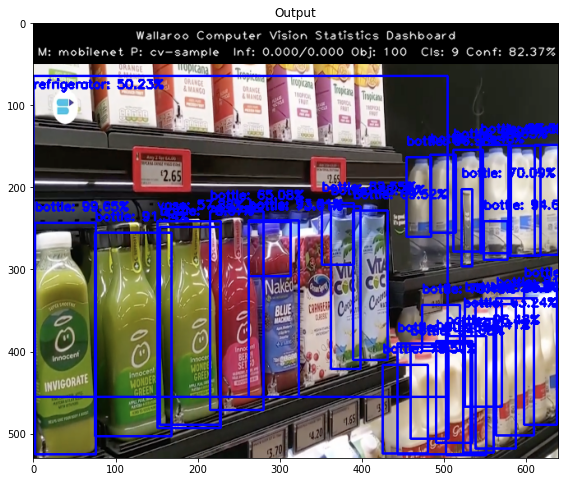

In [21]:
elapsed = 1.0
elasped = x86_time
sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : results,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)

### Deploy with ARM

We have demonstrated performing our sample inference using a standard pipeline deployment.  Now we will redeploy the same pipeline with the ARM architecture with the Wallaroo deployment setting `wallaroo.engine_config.Architecture.ARM` setting and applying it to the deployment configurations `arch` parameter.

In [22]:
from wallaroo.engine_config import Architecture
arm_deployment_config = wallaroo.deployment_config.DeploymentConfigBuilder().cpus(15).memory('16Gi').arch(Architecture.ARM).build()

pipeline.undeploy()
pipeline.deploy(deployment_config=arm_deployment_config)
pipeline.deploy()

Waiting for undeployment - this will take up to 45s .................................... ok
Waiting for deployment - this will take up to 45s ................ ok
 ok


name,cv-sample
created,2023-08-15 16:29:14.576736+00:00
last_updated,2023-08-15 16:34:35.327495+00:00
deployed,True
tags,
versions,"87fdff4f-e6c1-4245-b01a-a0cef9d70296, 33bb3ff4-946b-4444-9f06-26091cb56c0e, 39cfff0f-3568-46d5-b130-28e71fc2cfbc, d85773a5-380c-426a-9437-4b5554356841, 509aa270-60f4-48c5-9ba9-2f0af5778ed1, 0accc01a-4600-41d8-8a6b-262685b4ee8e, 88d0089e-7a82-4c21-b490-1a2eaa1d7a01"
steps,resnet


### ARM Inference

We will now perform the same inference we did with the standard deployment architecture, only this time through the ARM virtual machines.

In [23]:
startTime = time.time()
# pass the dataframe in 
results = pipeline.infer(dfImage, dataset=["*", "metadata.elapsed"])
endTime = time.time()
arm_time = endTime-startTime

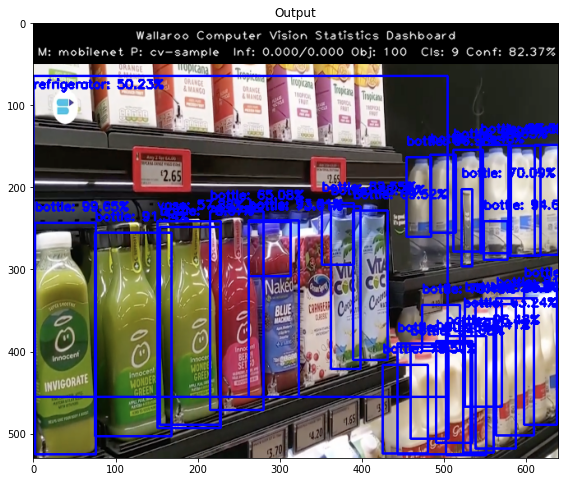

In [24]:
elapsed = 1.0
elasped = arm_time
sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : results,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)

### Compare Standard against Arm

With the two inferences complete, we'll compare the standard deployment architecture against the ARM architecture.

In [25]:
display(f"Standard architecture: {x86_time}")
display(f"ARM architecture: {arm_time}")

'Standard architecture: 2.5245113372802734'

'ARM architecture: 1.9362545013427734'

### Undeploy the Pipeline

With the inference complete, we can undeploy the pipeline and return the resources back to the Wallaroo instance.

In [26]:
pipeline.undeploy()

Waiting for undeployment - this will take up to 45s ..................................... ok


name,cv-sample
created,2023-08-15 16:29:14.576736+00:00
last_updated,2023-08-15 16:34:35.327495+00:00
deployed,False
tags,
versions,"87fdff4f-e6c1-4245-b01a-a0cef9d70296, 33bb3ff4-946b-4444-9f06-26091cb56c0e, 39cfff0f-3568-46d5-b130-28e71fc2cfbc, d85773a5-380c-426a-9437-4b5554356841, 509aa270-60f4-48c5-9ba9-2f0af5778ed1, 0accc01a-4600-41d8-8a6b-262685b4ee8e, 88d0089e-7a82-4c21-b490-1a2eaa1d7a01"
steps,resnet
